In [1]:
import numpy as np 
from sklearn.neighbors import KNeighborsClassifier 
import joblib
#from scipy.special import erf
import torch
from math import erf
from muller_brown_potential_simulations import muller_brown_potential

In [13]:
# load trajectory data and define states 

traj=np.load("../data/10000/traj_unperturb.npy"); traj=np.vstack(traj)
define_state_knn=joblib.load("define_state_for_MB_potential.joblib")
predict_closest_boundary=joblib.load("predict_closest_boundary.joblib")
boundary_points=np.load("boundary.npy")

knn_result=define_state_knn.predict(traj)  # state a =1; state b =2 ;domain =3

state_a=np.zeros(np.shape(traj)[0]); state_a[np.where(knn_result[:,0]==1)] =1
state_b=np.zeros(np.shape(traj)[0]); state_b[np.where(knn_result[:,0]==2)] =1
domain=np.zeros(np.shape(traj)[0]); domain[np.where(knn_result[:,0]==3)] =1
complement=np.zeros(np.shape(traj)[0]); complement[np.where(domain==0)]=1
# boundary is the index for the closest boundary point 
boundary=predict_closest_boundary.predict(traj)[:,0]

In [3]:
def build_gaussian_basis(traj,boundary_points,num_basis):
    num_frame=np.shape(traj)[0]

    # randomly pick 100 frames and compute their mean and variance to build gaussians 
    var_list=[] ;  mu_list=[] ; basis=[]
    
    for x in range(num_basis):
        random=np.random.randint(0,num_frame,size=100)
        mu=np.mean(traj[random],axis=0)
        var=np.mean(np.var(traj[random],axis=0)) # np.var computes variance for x and y separately. we then average the variances
        mu_list.append(mu)
        var_list.append(var)

        for frame in range(num_frame):
            g=np.exp(-1*(np.linalg.norm(traj[frame]-mu)**2)/(2*var))     
            state=int(domain[frame])
            s=1
            if state==1: # point in Domain 
                boundary_index=int(boundary[frame])  
                s_factor=10
                s=0.5*(erf((s_factor)*np.linalg.norm(traj[frame] - boundary_points[boundary_index]) - 3.5) + 1)

            basis.append(g*s)
    
    basis=np.asarray(basis).reshape((num_frame,num_basis),order='F')
    return basis, var_list, mu_list


In [4]:
result=build_gaussian_basis(traj,boundary_points,10)

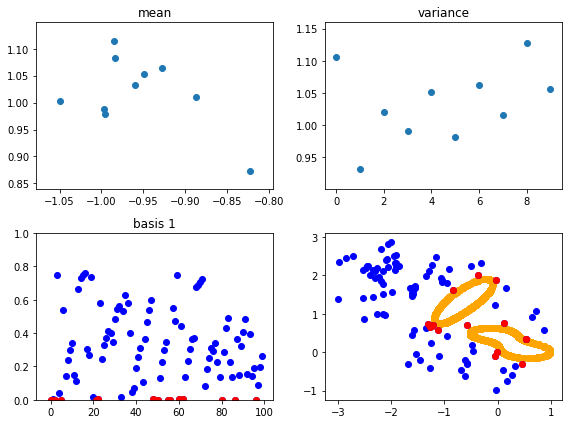

In [5]:
import matplotlib.pyplot as plt
d_index=np.where(domain==1)[0]
fig,ax = plt.subplots(2,2,figsize=(8,6))
ax[0,0].scatter(np.asarray(result[2])[:,0],np.asarray(result[2])[:,1])
ax[0,0].set_title("mean")
ax[0,1].scatter(range(len(result[1])),np.asarray(result[1]))
ax[0,1].set_title("variance")

first_30_points_in_domain=np.asarray(result[0])[:,0][d_index][:100]

highlight=[0, 2, 5, 21, 22, 48, 49, 50, 55, 56, 60, 62, 80, 86, 96]
ax[1,0].scatter(range(100),first_30_points_in_domain,c='b')
ax[1,0].set_title("basis 1")
ax[1,0].scatter(np.asarray(range(100))[highlight],first_30_points_in_domain[highlight],c='r')
ax[1,0].set_ylim(0,1)

ax[1,1].scatter(boundary_points[:,0], boundary_points[:,1],c='orange')

ax[1,1].scatter(traj[d_index][:100][:,0],traj[d_index][:100][:,1],c='b')
ax[1,1].scatter(traj[d_index][highlight][:,0],traj[d_index][highlight][:,1],c='r')

fig.tight_layout()

In [8]:
def build_guess_function(basis, state_b, domain):
        domain_index=np.where(domain==1)[0]
        complement_index=np.where(domain==0)[0]
        
        r=np.zeros(shape=np.shape(domain))
        r[complement_index]=state_b[complement_index]
        
        #set up A x =b equation to solve for x
        basis_DX50=basis[domain_index]
        basis_DcX50=basis[complement_index]
        r_DcX1=r[complement_index]        
        A=basis_DX50 .dot(basis_DX50.T)
        b=-1* basis_DX50 .dot(basis_DcX50.T) 
        b=b.dot(r_DcX1)
        gamma=np.linalg.solve(A,b)
        
        r[domain_index]=gamma
        
        return r




In [9]:
basis=result[0][:,0:10]
guess=build_guess_function(basis,state_b, domain)

MemoryError: 

In [ ]:
plt.scatter(range(1000),guess[:1000])

In [ ]:
    def compute_generator(x,y=None,dt=1,lag=1):
        if y is None :
            y=x
        N=np.shape(x)[0] # N = number of frames x number of trajectories  
        K=1/N * x[:-lag] .dot(y[lag:])
        S=1/N * x .dot(x.T)
        L= K-S/(lag*dt)
        return L
    
    def compute_committor(basis, guess, grad_basis=None, force=None,coeff_q0=None):
        if coeff_q0 is None:
            fLf= compute_generator(basis)
            # h is 0
            frf=compute_generator(basis, guess)
            coeff_q0 = np.linalg.solve(fLf, frf)
            gamma = np.diag(coeff_q0) * basis
            g = gamma + guess
            return g
        else:
            fLf=compute_generator(basis)
            q0_diag=np.diag(coeff_q0)
            right_side=basis .dot(force) .dot(grad_basis).dot(q0_diag)
            gamma=np.linalg.solve(fLf, right_side)
            g=gamma + guess